In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("urgent_care_images_master_final.csv")

# Stratified split (70% train, 15% val, 15% test)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)


Train: (6084, 2)
Val: (1304, 2)
Test: (1304, 2)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0
)

train_gen = datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)


Found 6084 validated image filenames belonging to 8 classes.
Found 1304 validated image filenames belonging to 8 classes.
Found 1304 validated image filenames belonging to 8 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

n_classes = len(train_gen.class_indices)
print("Number of classes:", n_classes)

model = models.Sequential([
    layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Number of classes: 8
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None

In [6]:
EPOCHS = 20

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/20
191/191 [==============================] - 31s 155ms/step - loss: 1.3506 - accuracy: 0.5789 - val_loss: 1.1024 - val_accuracy: 0.5997
Epoch 2/20
191/191 [==============================] - 29s 153ms/step - loss: 1.1632 - accuracy: 0.6054 - val_loss: 1.0838 - val_accuracy: 0.6127
Epoch 3/20
191/191 [==============================] - 29s 154ms/step - loss: 1.1087 - accuracy: 0.6228 - val_loss: 1.0364 - val_accuracy: 0.6495
Epoch 4/20
191/191 [==============================] - 29s 154ms/step - loss: 1.0613 - accuracy: 0.6303 - val_loss: 0.9659 - val_accuracy: 0.6710
Epoch 5/20
191/191 [==============================] - 30s 158ms/step - loss: 1.0248 - accuracy: 0.6423 - val_loss: 0.9062 - val_accuracy: 0.6917
Epoch 6/20
191/191 [==============================] - 30s 158ms/step - loss: 0.9707 - accuracy: 0.6594 - val_loss: 0.8779 - val_accuracy: 0.6856
Epoch 7/20
191/191 [==============================] - 34s 177ms/step - loss: 0.9525 - accuracy: 0.6662 - val_loss: 0.8657 - val_ac

In [7]:
loss, acc = model.evaluate(test_gen)
print(f"Test accuracy: {acc:.3f}")


41/41 [==============================] - 5s 133ms/step - loss: 0.7148 - accuracy: 0.7408
Test accuracy: 0.741


In [14]:
from tensorflow.keras.preprocessing import image


img = image.load_img("cut.jpg", target_size=(224, 224))  # <--- resize for your model!
img_array = image.img_to_array(img) / 255.
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)
class_idx = np.argmax(preds[0])
class_name = list(train_gen.class_indices.keys())[class_idx]
print("Predicted class:", class_name)



1/1 [==============================] - 0s 251ms/step
Predicted class: wound_laceration


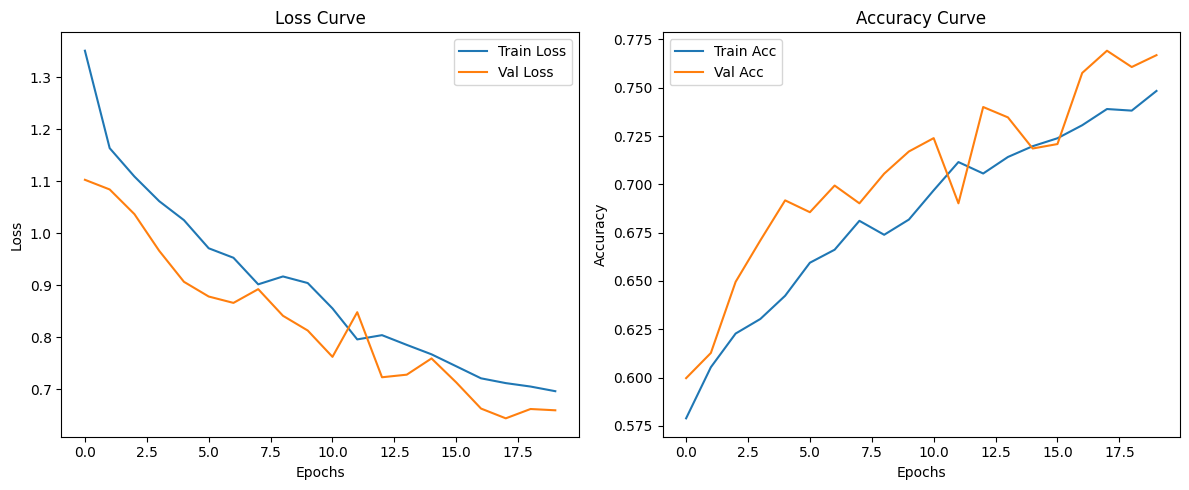

In [15]:


import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


41/41 [==============================] - 6s 130ms/step


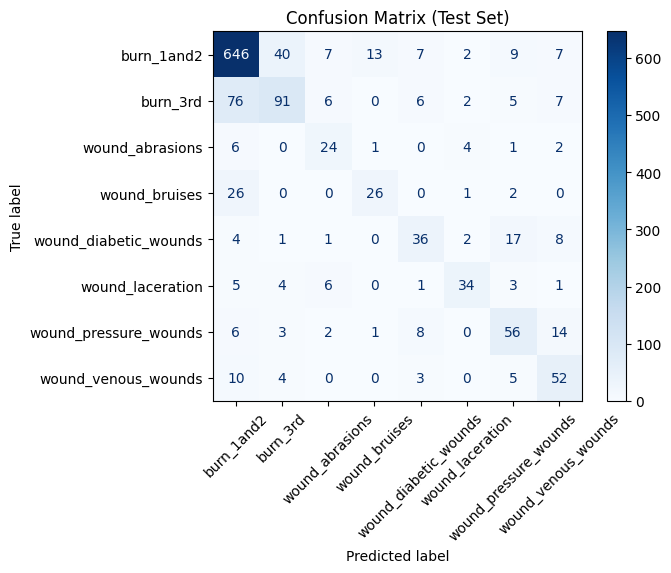

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions on test set
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

labels = list(train_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=labels))


                       precision    recall  f1-score   support

           burn_1and2       0.83      0.88      0.86       731
             burn_3rd       0.64      0.47      0.54       193
      wound_abrasions       0.52      0.63      0.57        38
        wound_bruises       0.63      0.47      0.54        55
wound_diabetic_wounds       0.59      0.52      0.55        69
     wound_laceration       0.76      0.63      0.69        54
wound_pressure_wounds       0.57      0.62      0.60        90
  wound_venous_wounds       0.57      0.70      0.63        74

             accuracy                           0.74      1304
            macro avg       0.64      0.62      0.62      1304
         weighted avg       0.74      0.74      0.73      1304



1/1 [==============================] - 0s 11ms/step


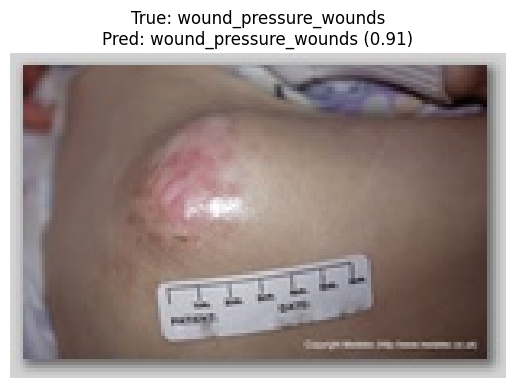

1/1 [==============================] - 0s 11ms/step


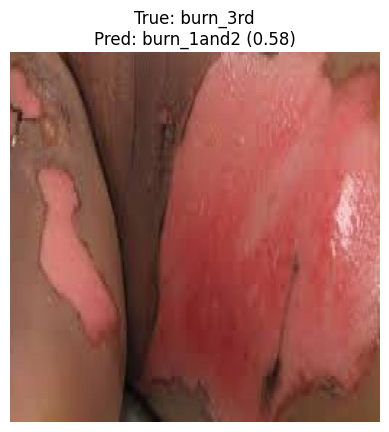

1/1 [==============================] - 0s 10ms/step


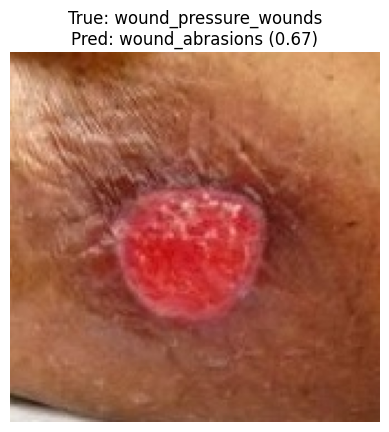

1/1 [==============================] - 0s 9ms/step


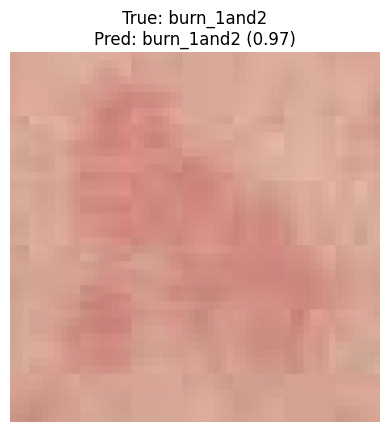

1/1 [==============================] - 0s 9ms/step


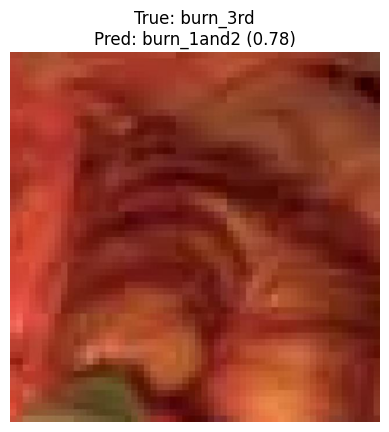

In [18]:
import random

for i in range(5):
    idx = random.randint(0, len(test_df)-1)
    img_path = test_df.iloc[idx]['filepath']
    label = test_df.iloc[idx]['label']

    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    class_idx = np.argmax(pred[0])
    class_name = labels[class_idx]
    conf = np.max(pred[0])

    plt.imshow(image.load_img(img_path))
    plt.title(f"True: {label}\nPred: {class_name} ({conf:.2f})")
    plt.axis('off')
    plt.show()


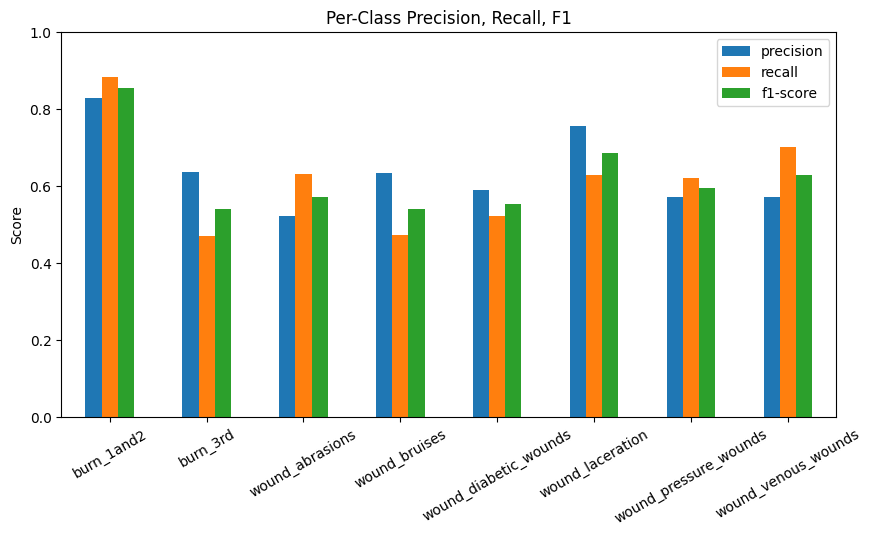

In [19]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Get metrics as dict
report = classification_report(y_true, y_pred_classes, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
report_df.iloc[:-3][['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax)
plt.title('Per-Class Precision, Recall, F1')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()


Number of misclassified images: 339


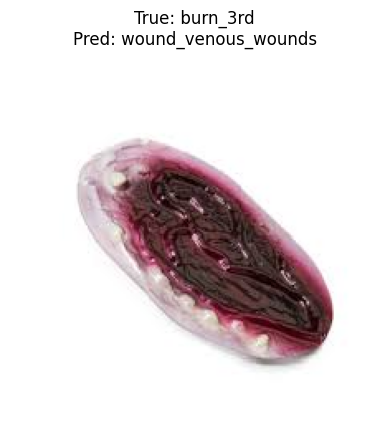

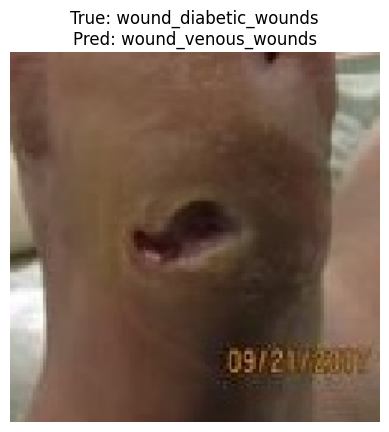

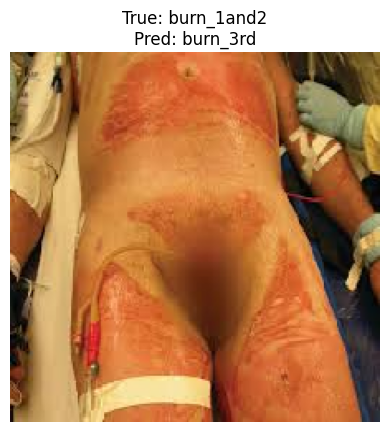

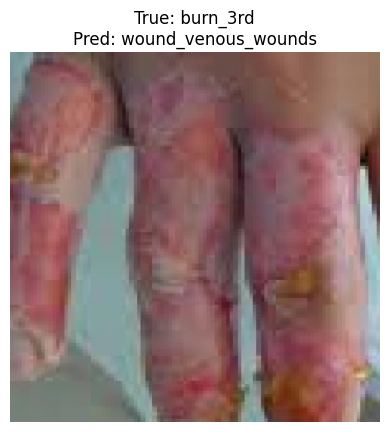

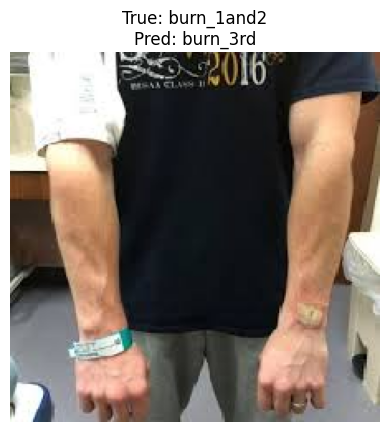

In [20]:
wrong = np.where(y_true != y_pred_classes)[0]
print("Number of misclassified images:", len(wrong))
# Show a few:
for i in wrong[:5]:
    img_path = test_df.iloc[i]['filepath']
    true_label = test_df.iloc[i]['label']
    pred_label = labels[y_pred_classes[i]]
    plt.imshow(image.load_img(img_path, target_size=IMG_SIZE))
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
    plt.show()
